# 1. Importing and Cleaning Data

In [110]:
import pandas as pd
import numpy as np
import csv

Loading the files

In [111]:
# Load the CSV file
csv_file_path = '/Users/gregorycrooks/Downloads/pitch_by_pitch_metadata 2.csv'
csv_data = pd.read_csv(csv_file_path, encoding='latin-1')

# Display the first few rows of the CSV to understand its structure
print(csv_data.head())

# Load the text file
text_file_path = '/Users/gregorycrooks/Downloads/pitches_folder/pitches'
with open(text_file_path, 'r') as file:
    text_data = file.readlines()

  column_name available_prior_to_pitch                   description
0         uid                      Yes                     unique id
1     game_pk                      Yes                unique game id
2        year                      Yes                          year
3        date                      Yes                          date
4   team_id_b                      Yes  team_id for the batting team


### Cleaning up the Data

In [144]:
import pandas as pd

# Assuming text_data contains the header and values
header = text_data[0]
values = text_data[1:100000]  # Assuming these are the rows

# Split the header by commas and remove double quotes
header = [col.replace('"', '') for col in header.split(",")]

# Create an empty list to hold valid rows
valid_rows = []

# Loop through each value row
for i in values:
    # Split each row by commas and remove double quotes from each value
    row = [val.replace('"', '') for val in i.split(",")]
    
    # Check for different row lengths
    if len(row) == 126:
        # If the length is 126, find and pop one value
        consecutive_empty_count = 0
        for index in range(len(row)):
            if row[index] == "":
                consecutive_empty_count += 1
                if consecutive_empty_count == 2:
                    # Pop one empty value
                    row.pop(index)
                    break  # Break after removing one value
            else:
                consecutive_empty_count = 0  # Reset if a non-empty value is found

    elif len(row) == 127:
        # If the length is 127, find and pop two values
        consecutive_empty_count = 0
        for index in range(len(row)):
            if row[index] == "":
                consecutive_empty_count += 1
                if consecutive_empty_count == 2:
                    # Pop two consecutive values
                    del row[index-1:index+1]  # Remove two consecutive values starting from index-1
                    break  # Break after removing two values
            else:
                consecutive_empty_count = 0  # Reset if a non-empty value is found

    # If the length is 125, do nothing (just append the row)
    if len(row) == 125:
        valid_rows.append(row)

# Create a DataFrame using the valid rows and the header as columns
df = pd.DataFrame(valid_rows, columns=header[:len(valid_rows[0])])  # Adjust columns if needed

# Output the DataFrame

Column count: 125 columns

Duplicated rows

In [113]:
duplicateRowsDF = df[df.duplicated()]
duplicateRowsDF

,uid,game_pk,year,date,team_id_b,team_id_p,inning,top,at_bat_num,pcount_at_bat,...,runner7_start,runner7_end,runner7_event,runner7_score,runner7_rbi,runner7_earned,created_at,added_at,modified_at,modified_by\n


Types for columns:

In [114]:
df.dtypes.value_counts()

object    125
dtype: int64

Null percentage:

In [115]:
# Replace empty strings with NaN
df = df.replace(r'^\s*$', np.nan, regex=True)

# Calculate the percentage of NaN values in each column
n = (df.isnull().sum() / len(df)) * 100

# Get columns with 100% NaN values
columns_with_all_nan = n[n == 100].index

# Drop columns with 100% NaN values
df = df.drop(columns=columns_with_all_nan)

# Feature Selection

Check To see where is the potential target variable

In [116]:
import pandas as pd

# Assuming df is your DataFrame already loaded

# Define a function to search for a substring within string fields
def search_string(s, search):
    # Ensure the input is string and perform a case-insensitive search
    return search in str(s).lower()

# Apply the search function to each element of the DataFrame
mask = df.apply(lambda x: x.map(lambda s: search_string(s, 'curveball')))

# Filter the DataFrame to keep only those rows where any column contains 'fastball'
fastball_df = df.loc[mask.any(axis=1)]


# Filter the DataFrame to show only the columns containing the string
columns_with_string = fastball_df.loc[:, mask.any()]

# Display the result
print(columns_with_string)

      spin_rate                                                 cc
2727    346.584  C.J. Wilson showed faith in Yorvit Torrealba b...
4207   1085.676  Kevin Correia showed faith in Ryan Doumit by t...
5033   1874.724  Kyle Davies showed faith in Matt Treanor by th...
5541   1550.267  Tommy Hanson showed faith in Brian McCann by t...
6204   1859.031  Colby Lewis showed faith in Yorvit Torrealba b...
...         ...                                                ...
94267   884.942  Chris Narveson showed faith in Jonathan Lucroy...
94449   226.255  Logan Ondrusek showed faith in Ryan Hanigan by...
96516  1710.971  Clay Buchholz showed faith in Jason Varitek by...
98110  1265.867  Jordan Zimmermann is still attacking Carlos Be...
98288   947.059  Tyler Chatwood showed faith in Hank Conger by ...

[104 rows x 2 columns]


We find that this column is a good indicator for the type of pitch

In [117]:
columns_with_string.cc.values

array(['C.J. Wilson showed faith in Yorvit Torrealba by throwing that curveball in the dirt with a runner on 3rd.',
       'Kevin Correia showed faith in Ryan Doumit by throwing that curveball in the dirt with a runner on 3rd.',
       'Kyle Davies showed faith in Matt Treanor by throwing that curveball in the dirt with a runner on 3rd.',
       'Tommy Hanson showed faith in Brian McCann by throwing that curveball in the dirt with a runner on 3rd.',
       'Colby Lewis showed faith in Yorvit Torrealba by throwing that curveball in the dirt with a runner on 3rd.',
       'Paul Maholm showed faith in Ryan Doumit by throwing that curveball in the dirt with a runner on 3rd.',
       'Jake Westbrook showed faith in Yadier Molina by throwing that curveball in the dirt with a runner on 3rd.',
       'Lance Cormier showed faith in Hector Gimenez by throwing that curveball in the dirt with a runner on 3rd.',
       'Brian Broderick showed faith in Ivan Rodriguez by throwing that curveball in th

Let's see if we can identify other types of pitches from this column; let's make a list of different types of baseball pitches

In [118]:
# Creating a list of baseball pitches
baseball_pitches = [
    # Fastballs
    "fastball",
    "cutter",
    "splitter",
    "forkball",
    
    # Breaking Balls
    "curveball",
    "slider",
    "slurve",
    "screwball",
    
    # Changeups
    "changeup",
    "palmball",
    "circle"
]

# Displaying the list of pitches
print(baseball_pitches)


['fastball', 'cutter', 'splitter', 'forkball', 'curveball', 'slider', 'slurve', 'screwball', 'changeup', 'palmball', 'circle']


Let's clean that column a little bit to make the visual a little more clear

In [119]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')

# Load this data into a DataFrame
columns_with_string = pd.DataFrame(columns_with_string)

# Define stopwords list
stop_words = set(stopwords.words('english'))

# Function to remove uppercase words and stopwords
def remove_uppercase_and_stopwords(text):
    tokens = word_tokenize(text)  # Tokenize text
    filtered_tokens = [word for word in tokens if word.islower() and word not in stop_words]  # Filter
    return ' '.join(filtered_tokens)

# Apply the function to the 'column_with_string'
columns_with_string['cc'] = columns_with_string['cc'].apply(remove_uppercase_and_stopwords)
columns_with_string

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/gregorycrooks/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/gregorycrooks/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,spin_rate,cc
2727,346.584,showed faith throwing curveball dirt runner 3rd
4207,1085.676,showed faith throwing curveball dirt runner 3rd
5033,1874.724,showed faith throwing curveball dirt runner 3rd
5541,1550.267,showed faith throwing curveball dirt runner 3rd
6204,1859.031,showed faith throwing curveball dirt runner 3rd
...,...,...
94267,884.942,showed faith throwing curveball dirt runner 3rd
94449,226.255,showed faith throwing curveball dirt runner 3rd
96516,1710.971,showed faith throwing curveball dirt runner 3rd
98110,1265.867,still attacking curveball even though hit one ...


Now that we have a better visual of the column; let's apply this to our entire dataframe by mapping out potential pitch types.

In [120]:
# List of baseball pitches
baseball_pitches = [
    "fastball",
    "cutter",
    "splitter",
    "forkball",
    "curveball",
    "slider",
    "slurve",
    "screwball",
    "changeup",
    "palmball",
    "circle"
]

# Define a function to check if any pitch type is in the description
def search_for_pitch(description, pitches):
    if isinstance(description, str):  # Ensure the entry is a string
        description = description.lower()  # Convert to lowercase for case-insensitive matching
        return any(pitch in description for pitch in pitches)
    return False  # If not a string, return False

# Apply the search function to each element of the DataFrame and create a mask
mask = df.applymap(lambda s: search_for_pitch(s, baseball_pitches))

# Filter the DataFrame to keep only those rows where any column contains one of the pitches
filter_df = df.loc[mask.any(axis=1)]


Cleaning cc for better visualization

In [121]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')

# Define stopwords list
stop_words = set(stopwords.words('english'))

# Function to remove uppercase words and stopwords
def remove_uppercase_and_stopwords(text):
    tokens = word_tokenize(text)  # Tokenize text
    filtered_tokens = [word for word in tokens if word.islower() and word not in stop_words]  # Filter
    return ' '.join(filtered_tokens)

# Apply the function to the 'column_with_string'
filter_df['cc'] = filter_df['cc'].apply(remove_uppercase_and_stopwords)
filter_df['cc']

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/gregorycrooks/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/gregorycrooks/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/var/folders/qz/2_cjtz1d25729cwclbl0hk640000gn/T/ipykernel_12624/607390207.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filter_df['cc'] = filter_df['cc'].apply(remove_uppercase_and_stopwords)


270                         missing strike zone last three
932      trying tie fastballs inside hitting pitches lo...
1016          showed faith throwing slider dirt runner 3rd
1211     trying tie fastballs inside hitting pitches lo...
1433                        missing strike zone last three
                               ...                        
99516                        fastball sitting past pitches
99524    really changeup working 's allowing average se...
99572         showed faith throwing slider dirt runner 3rd
99574                        fastball sitting past pitches
99580    trying tie fastballs inside hitting pitches lo...
Name: cc, Length: 1638, dtype: object

We look at strings matching the pitch name in the column

In [122]:
# Define a function to find and return the matching pitch type from the 'cc' column
def find_pitch(description, pitches):
    if isinstance(description, str):  # Ensure the entry is a string
        description = description.lower()  # Convert to lowercase for case-insensitive matching
        for pitch in pitches:
            if pitch in description:
                return pitch  # Return the matching pitch
    return None  # If no match, return None


filter_df['matching_pitch'] = filter_df['cc'].apply(lambda x: find_pitch(x, baseball_pitches))

/var/folders/qz/2_cjtz1d25729cwclbl0hk640000gn/T/ipykernel_12624/280650298.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filter_df['matching_pitch'] = filter_df['cc'].apply(lambda x: find_pitch(x, baseball_pitches))


### Selecting columns based on their description

In [123]:
# Get the list of column names from df
header = list(df.columns.values)

# Check if the values in 'column_name' of csv_data match any column names in df
csv_data['match_in_df'] = csv_data['column_name'].apply(lambda col: col if col in header else None)

# Check if the values in 'column_name' of csv_data match any column names in df
csv_data['match_in_df'] = csv_data['column_name'].apply(lambda col: col if col in header else None)

# Display the rows where there is a match in column names
matches = csv_data[csv_data['match_in_df'].notnull()]

# Drop rows where 'description' has NaN values
matches_no_na = matches.dropna(subset=['description'])



Filtering to find id variables:

In [124]:
# Filter for descriptions containing "id" which implies these are identifier columns
id_columns = matches_no_na[matches_no_na['description'].str.contains("id")]

pitch_columns = matches_no_na[matches_no_na['description'].str.contains("pitch")]

# List the column names identified as having "id" in their description
id_column_names = id_columns['column_name'].tolist()

pitch_column_names = pitch_columns['column_name'].tolist()

# Filter df to keep only those columns identified as id columns
id_df = df[id_column_names]

pitch_df = df[pitch_column_names]

Let's look at column in relation with pitches

In [125]:
pitch_df

,team_id_p,pcount_at_bat,pcount_pitcher,is_final_pitch,pitcher_id,away_team_runs,home_team_runs,pitch_des,pitch_id,type,...,vx0,ax,break_length,break_y,break_angle,pitch_type,type_confidence,zone,nasty,spin_dir
0,118,1,1,0,460024,0,0,Ball,3,B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,118,2,2,0,460024,0,0,Ball,4,B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,118,3,3,0,460024,0,0,Called Strike,5,S,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,118,4,4,1,460024,0,NaN,out(s),6,X,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,118,1,5,0,460024,0,0,Called Strike,10,S,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99591,117,1,9,0,472551,3,4,Called Strike,467,S,...,-7.843,14.949,4.400,23.800,-44.100,FF,2.000,13,38,142.996
99592,117,2,10,0,472551,3,4,Ball,468,B,...,-1.673,17.720,5.600,23.800,-45.800,FF,2.000,14,54,133.449
99593,117,3,11,0,472551,3,4,Foul,469,S,...,-4.203,22.390,6.700,23.800,-48.000,FT,2.000,9,44,122.426
99594,117,4,12,0,472551,3,4,Ball,470,B,...,-1.594,18.734,5.300,23.800,-51.500,FF,2.000,14,49,135.269


Let's find the potential target variable

In [126]:
pitch_info = pitch_df.loc[:, ["pitch_des", "pitch_id", "type", "spin_dir"]]

In [127]:
pitch_info.type.value_counts()

S         43558
B         36624
X         18397
Ball          4
185928        2
          ...  
10952         1
231142        1
234137        1
1852          1
20435         1
Name: type, Length: 994, dtype: int64

Group info with the earlier matching strings:

In [130]:
pitch_df = filter_df.loc[:, ["pitch_des", "pitch_id", "type", "spin_dir", "matching_pitch"]]
# Group the DataFrame by 'matching_pitch' column
grouped_df = pitch_df.groupby('matching_pitch')

# Group the DataFrame by 'matching_pitch' and count the occurrences in each group
pitch_count = filter_df.groupby(['matching_pitch', "type"]).size()

# Display the counts by 'matching_pitch'
print(pitch_count)

matching_pitch  type  
changeup        10354      1
                181101     1
                235019     1
                24501      1
                32222      1
                          ..
slider          S         20
                X         12
splitter        B         12
                S          4
                X          4
Length: 370, dtype: int64


Speed Direction by type

In [131]:
pitch_df.spin_dir = pitch_df.spin_dir.astype(float)
# Grouping the DataFrame by 'type' and getting the mean spin direction for each type
speed_direction_by_type = pitch_df.groupby('type')['spin_dir'].mean().reset_index()

# Displaying the result
speed_direction_by_type

,type,spin_dir
0,10020,1729.062000
1,10042,729.751000
2,10100,452.051000
3,10113,2522.299000
4,10140,285.587000
...,...,...
771,928,1477.993000
772,948,2682.711000
773,B,149.394210
774,S,183.056317


Info about strikes

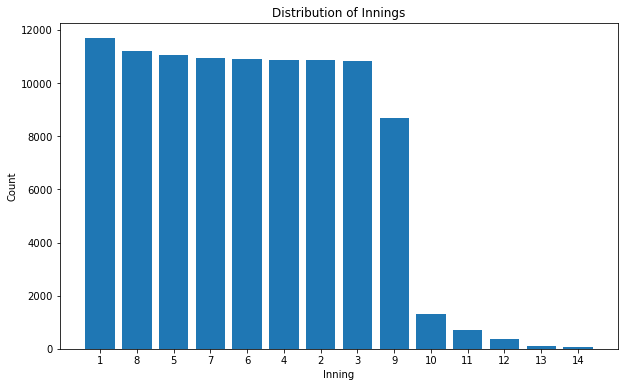

In [132]:

# Assuming df.inning.value_counts() is available
inning_counts = df.inning.value_counts()

# Create the bar plot
plt.figure(figsize=(10, 6))
plt.bar(inning_counts.index, inning_counts.values)

# Set labels and title
plt.xlabel('Inning')
plt.ylabel('Count')
plt.title('Distribution of Innings')

# Show the plot
plt.show()


Difference between weight of bat and end of bat

In [133]:
filter_df.at_bat_num.value_counts()

50     41
44     36
46     36
45     36
39     35
       ..
90      2
95      1
85      1
103     1
83      1
Name: at_bat_num, Length: 90, dtype: int64

Filtering to find variables about geospatial data:

In [134]:
filter_df

,uid,game_pk,year,date,team_id_b,team_id_p,inning,top,at_bat_num,pcount_at_bat,...,cc,on_1b,on_2b,on_3b,runner1_id,created_at,added_at,modified_at,modified_by\n,matching_pitch
270,14143497,286874,2011,2011-03-31,118,108,8,0,66,5,...,missing strike zone last three,NaN,NaN,NaN,NaN,2016-03-03 21:33:20,2016-03-03 21:33:20,2016-03-03 21:33:20,1\n,None
932,14146640,286877,2011,2011-03-31,113,158,1,0,8,2,...,trying tie fastballs inside hitting pitches lo...,NaN,NaN,NaN,NaN,2016-03-03 21:33:22,2016-03-03 21:33:22,2016-03-03 21:33:22,1\n,fastball
1016,14146724,286877,2011,2011-03-31,113,158,3,0,31,3,...,showed faith throwing slider dirt runner 3rd,457803,NaN,458015,NaN,2016-03-03 21:33:22,2016-03-03 21:33:22,2016-03-03 21:33:22,1\n,slider
1211,14148813,286878,2011,2011-03-31,135,138,1,1,3,2,...,trying tie fastballs inside hitting pitches lo...,NaN,NaN,NaN,NaN,2016-03-03 21:33:24,2016-03-03 21:33:24,2016-03-03 21:33:24,1\n,fastball
1433,14149037,286878,2011,2011-03-31,135,138,8,1,59,5,...,missing strike zone last three,430583,408305,NaN,NaN,2016-03-03 21:33:24,2016-03-03 21:33:24,2016-03-03 21:33:24,1\n,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99516,14929195,287243,2011,2011-04-26,138,117,5,1,36,1,...,fastball sitting past pitches,NaN,NaN,NaN,NaN,2016-03-03 21:40:08,2016-03-03 21:40:08,2016-03-03 21:40:08,1\n,fastball
99524,14929203,287243,2011,2011-04-26,138,117,5,1,37,6,...,really changeup working 's allowing average se...,407812,NaN,NaN,NaN,2016-03-03 21:40:08,2016-03-03 21:40:08,2016-03-03 21:40:08,1\n,changeup
99572,14929251,287243,2011,2011-04-26,117,138,6,0,51,2,...,showed faith throwing slider dirt runner 3rd,407849,150324,447816,NaN,2016-03-03 21:40:08,2016-03-03 21:40:08,2016-03-03 21:40:08,1\n,slider
99574,14929253,287243,2011,2011-04-26,117,138,6,0,51,4,...,fastball sitting past pitches,407849,150324,447816,NaN,2016-03-03 21:40:08,2016-03-03 21:40:08,2016-03-03 21:40:08,1\n,fastball


In [135]:
trajectory_df = filter_df.iloc[:, [23] + list(range(38, 68))]  
# Step 3: Replace hyphens with periods in the 'b_height' column of trajectory_df
trajectory_df['b_height'] = trajectory_df['b_height'].replace('-', '.', regex=True)

trajectory_df = trajectory_df.drop(columns=["pitch_tfs_zulu", "sv_id", "pitch_type"])
# Step 4: Put the modified 'b_height' column back into the original DataFrame
trajectory_df['b_height'] = trajectory_df['b_height']

for column in trajectory_df.columns:
    trajectory_df[column] = pd.to_numeric(trajectory_df[column], errors='coerce')
# Adding 'matching_pitch' to trajectory_df
trajectory_df['matching_pitch'] = filter_df['matching_pitch']

/var/folders/qz/2_cjtz1d25729cwclbl0hk640000gn/T/ipykernel_12624/2120177464.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trajectory_df['b_height'] = trajectory_df['b_height'].replace('-', '.', regex=True)


Finding most highly correlated measurement variables

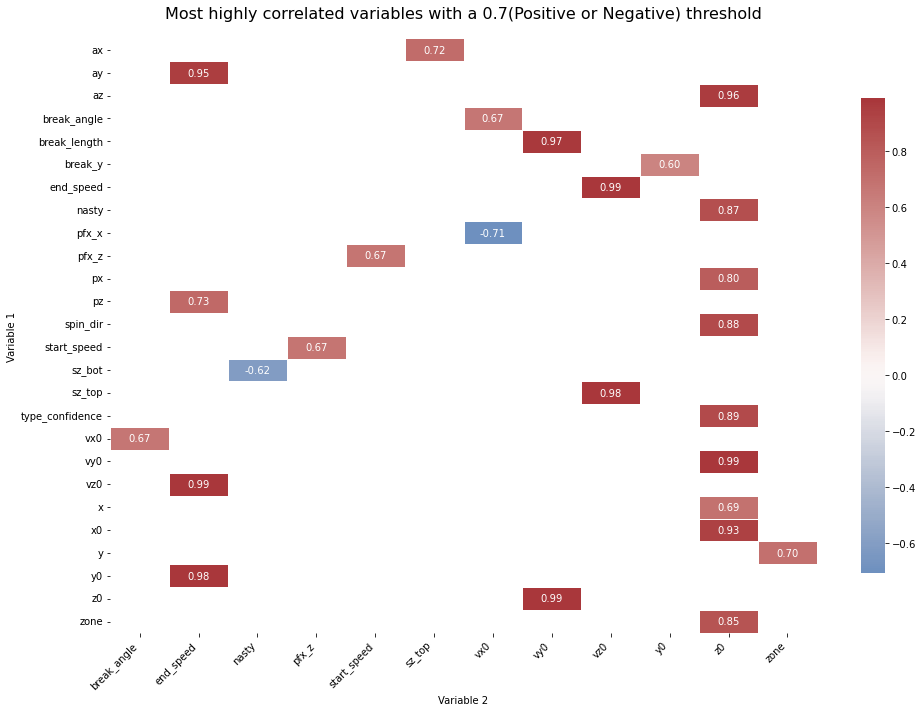

In [136]:
import matplotlib.pyplot as plt
import seaborn as sns

correlation_matrix = trajectory_df.corr()
# Find pairs with an absolute correlation of 60% or more
high_corr_pairs = correlation_matrix.stack().reset_index()
high_corr_pairs.columns = ['Variable 1', 'Variable 2', 'Correlation']
high_corr_pairs = high_corr_pairs[high_corr_pairs['Variable 1'] != high_corr_pairs['Variable 2']]
high_corr_pairs = high_corr_pairs[(high_corr_pairs['Correlation'].abs() >= 0.6) & (high_corr_pairs['Correlation'].abs() < 1.0)]
high_corr_pairs = high_corr_pairs.sort_values(by='Correlation', ascending=False)
unique_high_corr_pairs = high_corr_pairs.groupby('Variable 1').first().reset_index()
pivot_table = unique_high_corr_pairs.pivot(index='Variable 1', columns='Variable 2', values='Correlation')
# Plot the heatmap using Seaborn
plt.figure(figsize=(14, 10))
sns.heatmap(pivot_table, annot=True, cmap='vlag', center=0, linewidths=1, linecolor='white', cbar_kws={'shrink': 0.8}, fmt='.2f', annot_kws={'size': 10})

# Customize the heatmap for better visual appeal
plt.title('Most highly correlated variables with a 0.7(Positive or Negative) threshold', fontsize=16, pad=20)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

# Feature engineer: Average of start speed to end speed:

- Four-seam Fastball: little to no movement and 85-100 mph

In [137]:
# Calculating the average between 'start_speed' and 'end_speed' and creating a new column
trajectory_df['average_speed'] = (trajectory_df['start_speed'].astype(float) + trajectory_df['end_speed'].astype(float)) / 2
trajectory_df['average_speed']

270      43.60
932      88.30
1016     84.85
1211     88.35
1433     40.66
         ...  
99516    43.81
99524    77.05
99572    81.85
99574    42.23
99580    89.30
Name: average_speed, Length: 1638, dtype: float64

find the average speed by matching_pitch

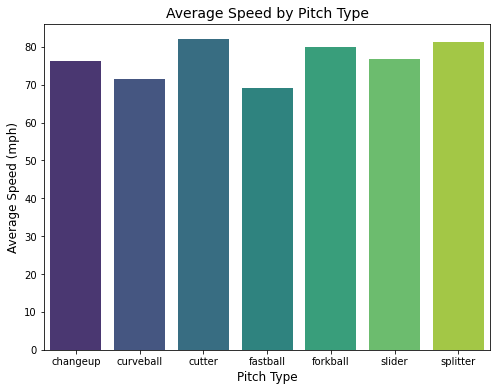

In [138]:
import matplotlib.pyplot as plt
import seaborn as sns
# Calculating the average between 'start_speed' and 'end_speed' and creating a new column
trajectory_df['average_speed'] = (trajectory_df['start_speed'].astype(float) + trajectory_df['end_speed'].astype(float)) / 2

# Group by 'matching_pitch' and calculate the mean of 'average_speed'
average_speed_by_pitch = trajectory_df.groupby('matching_pitch')['average_speed'].mean().reset_index()

# Create a bar plot using Seaborn
plt.figure(figsize=(8, 6))
sns.barplot(x='matching_pitch', y='average_speed', data=average_speed_by_pitch, palette='viridis')

# Add title and labels
plt.title('Average Speed by Pitch Type', fontsize=14)
plt.xlabel('Pitch Type', fontsize=12)
plt.ylabel('Average Speed (mph)', fontsize=12)

# Show the plot
plt.show()

Could we use other metrics to identify the pitch type?

In [139]:
# Calculating the average between 'start_speed' and 'end_speed' and creating a new column
trajectory_df['average_speed'] = (trajectory_df['start_speed'].astype(float) + trajectory_df['end_speed'].astype(float)) / 2

# Group by 'matching_pitch' and calculate the mean of all numerical columns
average_metrics_by_pitch = trajectory_df.groupby('matching_pitch').mean()

average_metrics_by_pitch

,b_height,x,y,start_speed,end_speed,sz_top,sz_bot,pfx_x,pfx_z,px,...,ay,break_length,break_y,break_angle,type_confidence,zone,nasty,spin_dir,spin_rate,average_speed
matching_pitch,,,,,,,,,,,,,,,,,,,,,
changeup,6.017632,107.939868,148.854507,81.556579,70.854211,3.232632,1.225658,-0.274737,4.354105,0.002224,...,22.544289,8.836842,23.060526,1.453521,2.130868,10.421053,52.902855,290.940184,1593.846465,76.205395
curveball,6.031100,92.738400,184.411915,76.219000,66.802400,3.271200,1.759400,2.434200,-6.003420,0.391560,...,22.509580,14.153000,21.840000,-6.064894,2.085290,14.330000,38.167300,225.202560,1464.231872,71.510700
cutter,5.962143,101.596071,148.016154,87.910714,76.083929,3.259643,1.549643,0.848571,6.101393,0.234429,...,25.690643,6.721429,22.053571,-3.742308,1.948750,9.857143,53.089714,237.815964,1386.463308,81.997321
fastball,5.989421,120.090484,144.830462,86.015266,52.193882,2.697148,0.871928,1.286670,4.481404,0.870593,...,20.679921,12.443550,15.070769,4.071098,4.522799,21.173964,96.352624,775.535420,1993.362206,69.104574
forkball,6.400000,82.400000,178.730000,83.900000,76.100000,3.400000,1.630000,-6.280000,11.550000,0.609000,...,28.429000,5.000000,23.700000,23.700000,0.866000,14.000000,48.000000,208.420000,2327.710000,80.000000
slider,6.007710,93.623359,184.469145,83.401527,69.904656,3.239618,1.543817,1.173206,0.897565,0.622878,...,23.191336,10.232061,20.859542,-4.016239,2.564115,15.916031,50.044053,237.338809,829.438701,76.653092
splitter,5.882500,103.346500,178.475500,84.435000,78.295000,3.342000,1.546000,-3.944000,2.692500,-0.241850,...,24.558050,8.250000,23.840000,11.595000,1.725700,11.850000,40.150000,216.378000,1580.150500,81.365000


Let's see if we can use these features to predict the type of pitch in the other rows in the dataframe

Let's select the target variable: matching_pitch

In [140]:
# Step 1: Replace infinity with NaN and then fill NaN values with the column mean
trajectory  = trajectory_df.replace([np.inf, -np.inf], np.nan, inplace=True)
trajectory  = trajectory_df.fillna(trajectory_df.mean(), inplace=True)

/var/folders/qz/2_cjtz1d25729cwclbl0hk640000gn/T/ipykernel_12624/3260242675.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  trajectory  = trajectory_df.fillna(trajectory_df.mean(), inplace=True)


In [141]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
X = trajectory_df.drop(columns=['matching_pitch'])
y = trajectory_df.matching_pitch.astype('str')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 5: Initialize and train the Logistic Regression model
clf = LogisticRegression(random_state=0, max_iter=1000)
clf.fit(X_train, y_train)
# Step 5: Initialize and train the Logistic Regression model
clf = LogisticRegression(random_state=0, max_iter=1000)
clf.fit(X_train, y_train)

# Step 6: Make predictions on the test set
y_pred = clf.predict(X_test)

# Step 7: Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

/Users/gregorycrooks/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.7652439024390244

Classification Report:
               precision    recall  f1-score   support

        None       0.75      0.87      0.80        87
    changeup       0.83      0.23      0.36        22
   curveball       0.75      0.90      0.82        20
      cutter       0.00      0.00      0.00         3
    fastball       0.77      0.82      0.80       166
      slider       0.80      0.62      0.70        26
    splitter       0.00      0.00      0.00         4

    accuracy                           0.77       328
   macro avg       0.56      0.49      0.50       328
weighted avg       0.75      0.77      0.74       328



/Users/gregorycrooks/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/gregorycrooks/opt/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/gregorycrooks/opt/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: 

Using the original dataframe to predict on the original dataframe

In [ ]:
common_columns = list(set(X.columns).intersection(df.columns))
common_columns

['y0',
 'spin_rate',
 'spin_dir',
 'az',
 'break_length',
 'b_height',
 'y',
 'break_angle',
 'vy0',
 'pfx_z',
 'pfx_x',
 'sz_top',
 'vx0',
 'nasty',
 'pz',
 'sz_bot',
 'z0',
 'x0',
 'zone',
 'end_speed',
 'ay',
 'vz0',
 'ax',
 'start_speed',
 'break_y',
 'type_confidence',
 'x',
 'px']

Predicting the output on the original dataframe

In [146]:
common_columns = list(set(X.columns).intersection(df.columns))
# Step 2: Convert common columns in df to float (handling conversion errors)
df[common_columns] = df[common_columns].apply(pd.to_numeric, errors='coerce')

# Handle missing values after conversion
df[common_columns] = df[common_columns].fillna(0)  # Replace NaN with 0 or any appropriate value

# Step 2: Check if the data in common columns is valid
if df[common_columns].empty:
    raise ValueError("The data for prediction is empty or invalid.")
# Step 1: Replace infinity with NaN and then fill NaN values with the column mean
df  = df.replace([np.inf, -np.inf], np.nan, inplace=True)
df  = df.fillna(trajectory_df.mean(), inplace=True)
# Step 3: Predict using only the common numerical columns
predicted_pitches = clf.predict(df[common_columns])

# Step 4: Add the predictions as a new column in the original DataFrame
df['predicted_pitch'] = predicted_pitches

# Display the original DataFrame with predictions
print(df)

AttributeError: 'NoneType' object has no attribute 'fillna'